In [1]:
# Numerical Operations
import math
import numpy as np

import os
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Pytorch
import torch 
import torch.nn as nn

from torch_geometric.data import Data, Batch
import torch_geometric.transforms as T

from models.simulator import Simulator

from method.Scaler import GaussianScaler
from method.plot_field import plot_one_field, plot_time_series

C:\Users\lyd\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
#import test data
edge = np.load('./data/edge_index_LRGNN.npy')
H_test = np.load('./data/H_test.npy')
C_test = np.load('./data/C_test.npy')
logk_grid_all_test = np.load('./data/logk_grid_all_test.npy')
logk_test = logk_grid_all_test[:,:,0]
logk_grid_all_test.shape       # (N,girds,features)    features:(value,x,y)

(1000, 1637, 3)

In [3]:
#one-hot code
a = np.array([982])   # point source
b = np.arange(1637)   # others 
b = np.setdiff1d(b, a)     
edge_index = edge
num_nodes = max(np.max(a), np.max(b), ) + 1
node_types = np.zeros(num_nodes, dtype=int)
node_types[a] = 1
node_types[b] = 0
node_type_one_hot = torch.nn.functional.one_hot(torch.tensor(node_types).to(torch.int64), num_classes=2)

In [4]:
#Normlizer
normalizer_logk_2 = GaussianScaler.load("./weight/logk_scaler.npz")
normalizer_h = GaussianScaler.load("./weight/h_scaler.npz")
normalizer_c = GaussianScaler.load("./weight/c_scaler.npz")

In [5]:
#logk transform
norm_logk = normalizer_logk_2.transform(logk_test)

In [6]:
transformer = T.Compose([
    T.Cartesian(),
    T.Distance(norm=True),
])

In [7]:
data_list=[]
pos = torch.as_tensor(logk_grid_all_test[0][:, 1:], dtype=torch.float32)
edge_index = torch.as_tensor(edge, dtype=torch.long)
pos = torch.as_tensor(pos, dtype=torch.float32)
(row, col) = edge_index

In [8]:
for i in range(logk_test.shape[0]):
    x = norm_logk[i].reshape(1637,-1)
    x = np.concatenate((x,node_type_one_hot.clone().detach()),axis=-1)
    x = torch.tensor(x, dtype=torch.float32)
    data = Data(x=x, edge_index=edge_index, pos=pos)
    data = transformer(data)
    data.edge_attr = data.edge_attr.to(torch.float32) 
    data.pos = data.pos.to(torch.float32)  
    data_list.append(data)

In [9]:
#LRGNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
simulator = Simulator(message_passing_num=20, node_input_size=3, edge_input_size=3, device=device)
net = simulator
checkpoint_mesh_net = torch.load(f'./weight/LRGNN_weight.pth')
net.load_state_dict(checkpoint_mesh_net)
simulator

Simulator model initialized


Simulator(
  (model): EncoderProcesserDecoder(
    (encoder): Encoder(
      (eb_encoder): Sequential(
        (0): Sequential(
          (0): Linear(in_features=3, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
          (3): ReLU()
          (4): Linear(in_features=128, out_features=128, bias=True)
          (5): ReLU()
          (6): Linear(in_features=128, out_features=128, bias=True)
        )
        (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (nb_encoder): Sequential(
        (0): Sequential(
          (0): Linear(in_features=3, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
          (3): ReLU()
          (4): Linear(in_features=128, out_features=128, bias=True)
          (5): ReLU()
          (6): Linear(in_features=128, out_features=128, bias=True)
        )
        (1): LayerNorm((128,), eps=1e-05, elemen

In [10]:
Num = 1

In [11]:
data_test = data_list[Num:Num+1]

In [12]:
#Run
pred_val_h_c_list = []
for data in data_test:     
    data = data.to(device) 
    with torch.no_grad():
        pred_h = net(data,)
        predicted = pred_h[0] if isinstance(pred_h, tuple) else pred_h
        predicted = predicted.cpu().detach().numpy()             
        pred_val_h_c_list.append(predicted)
pred_val_h_c_list=np.array(pred_val_h_c_list)

norm_h_val = pred_val_h_c_list[:,:,0:1]
norm_c_val = pred_val_h_c_list[:,:,1:]

pred_h_last = normalizer_h.inverse_transform(norm_h_val)
pred_c_last = normalizer_c.inverse_transform(norm_c_val)

pred_h_last = pred_h_last.squeeze()
pred_c_last = pred_c_last.squeeze()

pred_h_last = np.clip(pred_h_last, 0, None) 
pred_c_last = np.clip(pred_c_last, 0, None)  

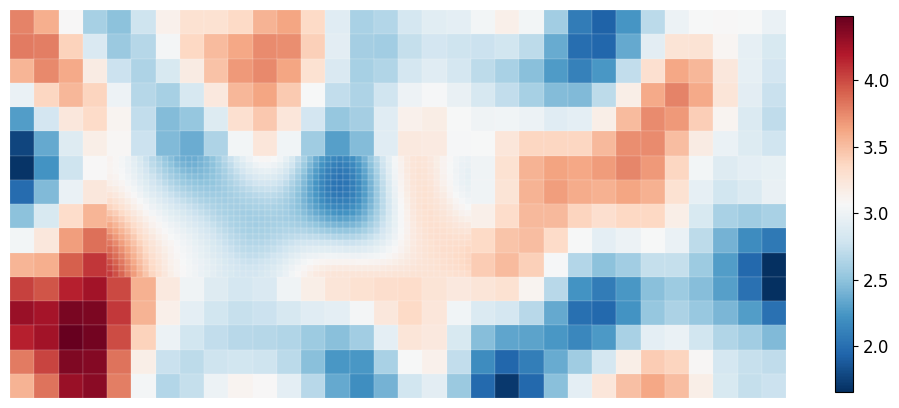

In [13]:
#logK
plot_one_field(logk_test[Num])

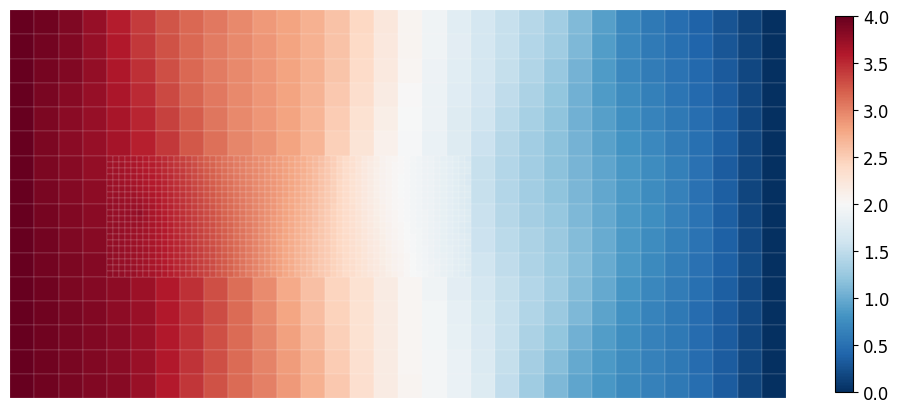

In [14]:
# true H 
plot_one_field(H_test[Num])

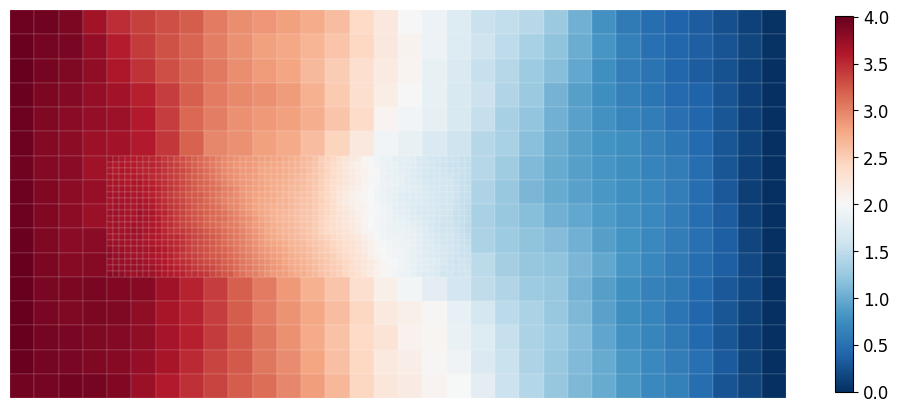

In [15]:
#LRGNN pred H 
plot_one_field(pred_h_last)

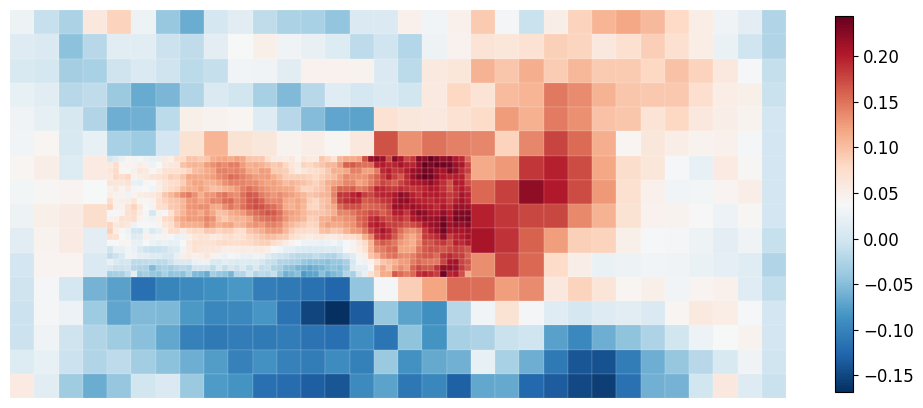

In [16]:
#LRGNN pred H error
plot_one_field(H_test[Num] - pred_h_last)

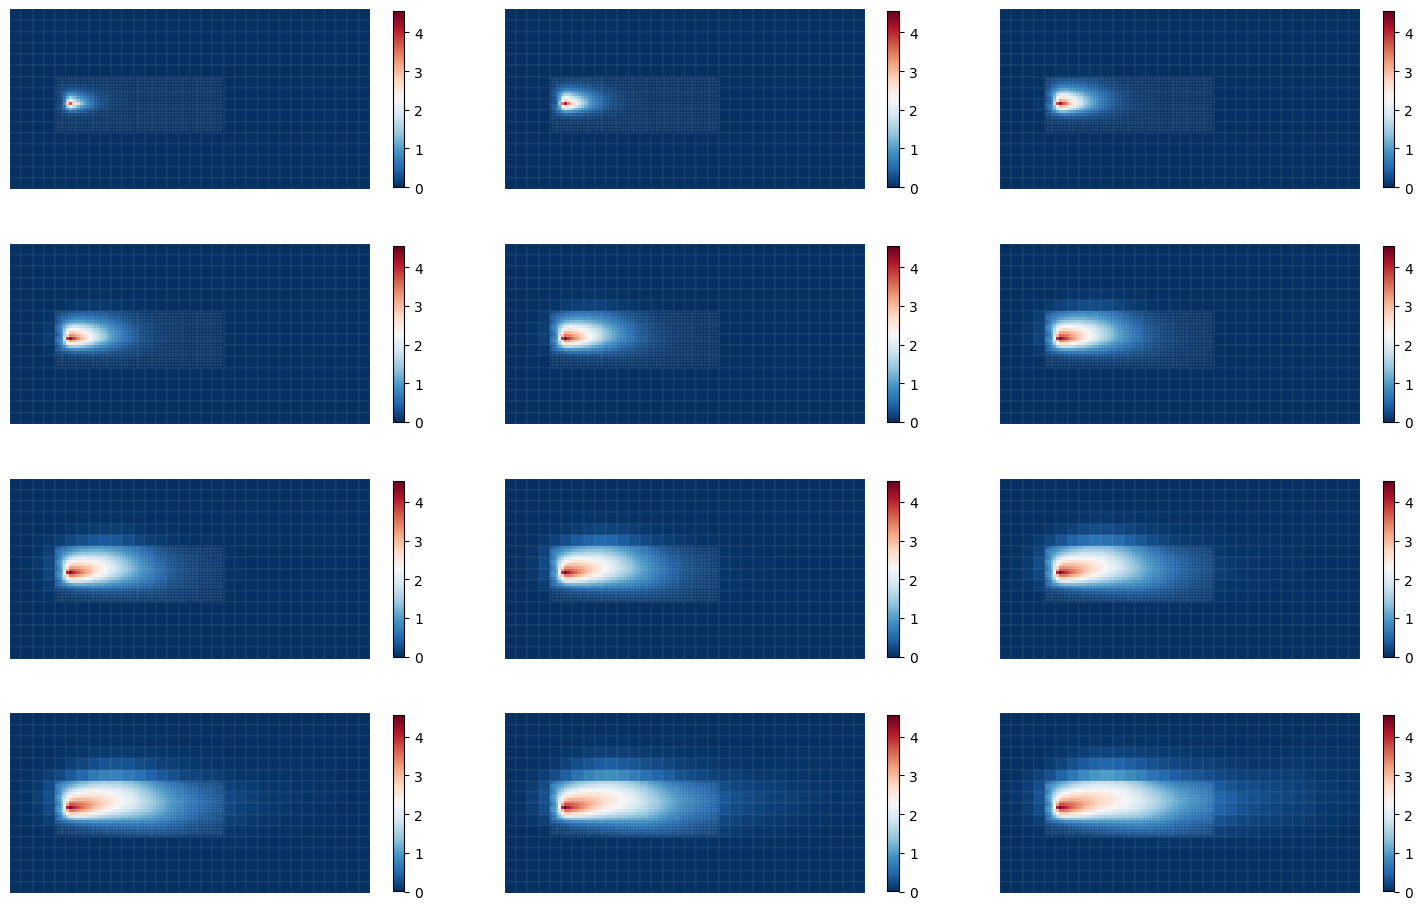

In [17]:
# true C
plot_time_series(C_test[Num].transpose(1,0))

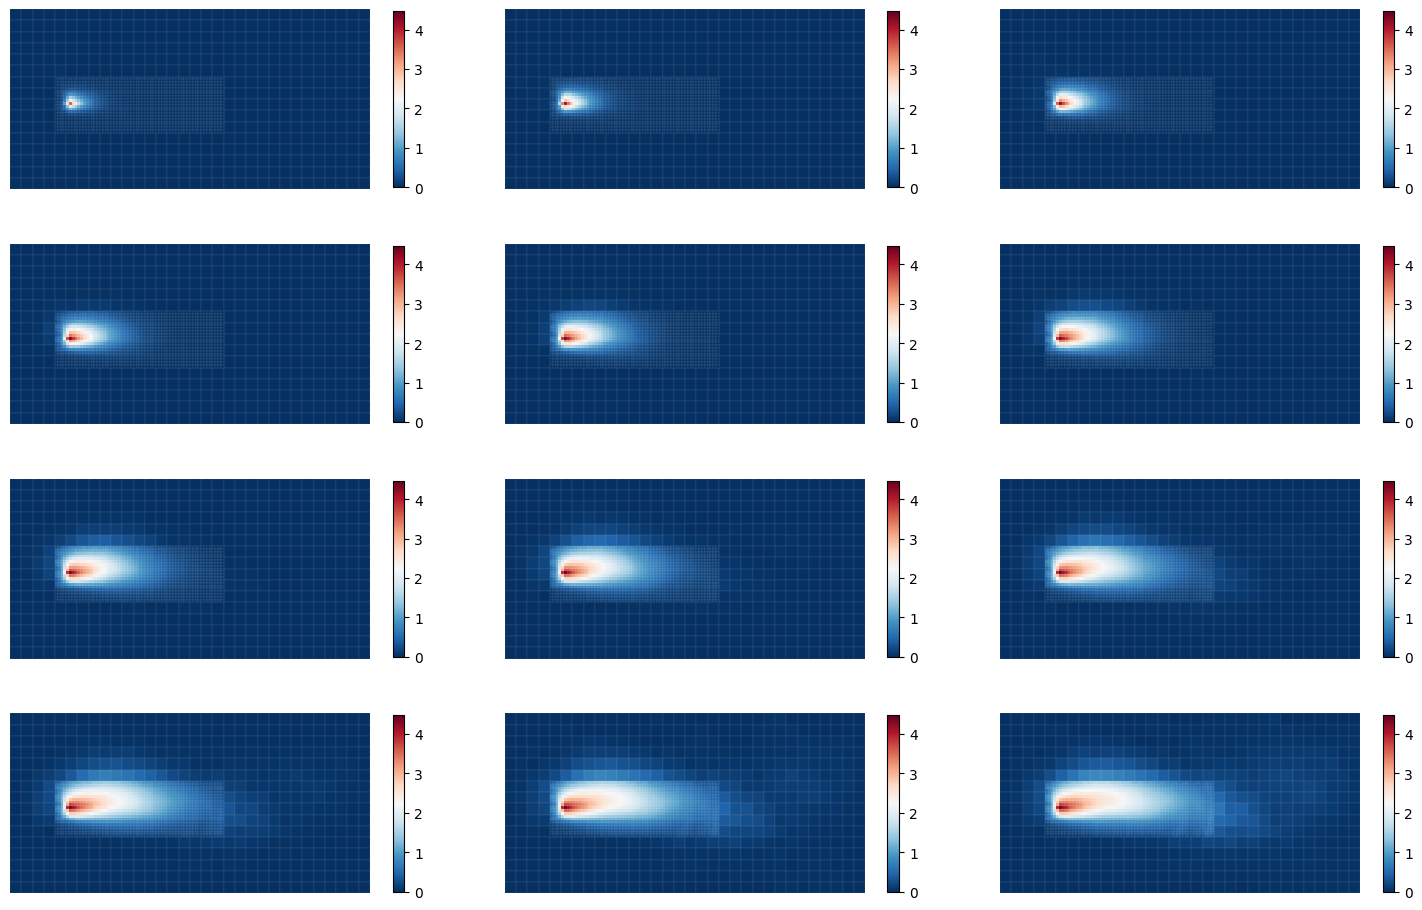

In [18]:
#LRGNN pred C
plot_time_series(pred_c_last.transpose(1,0))

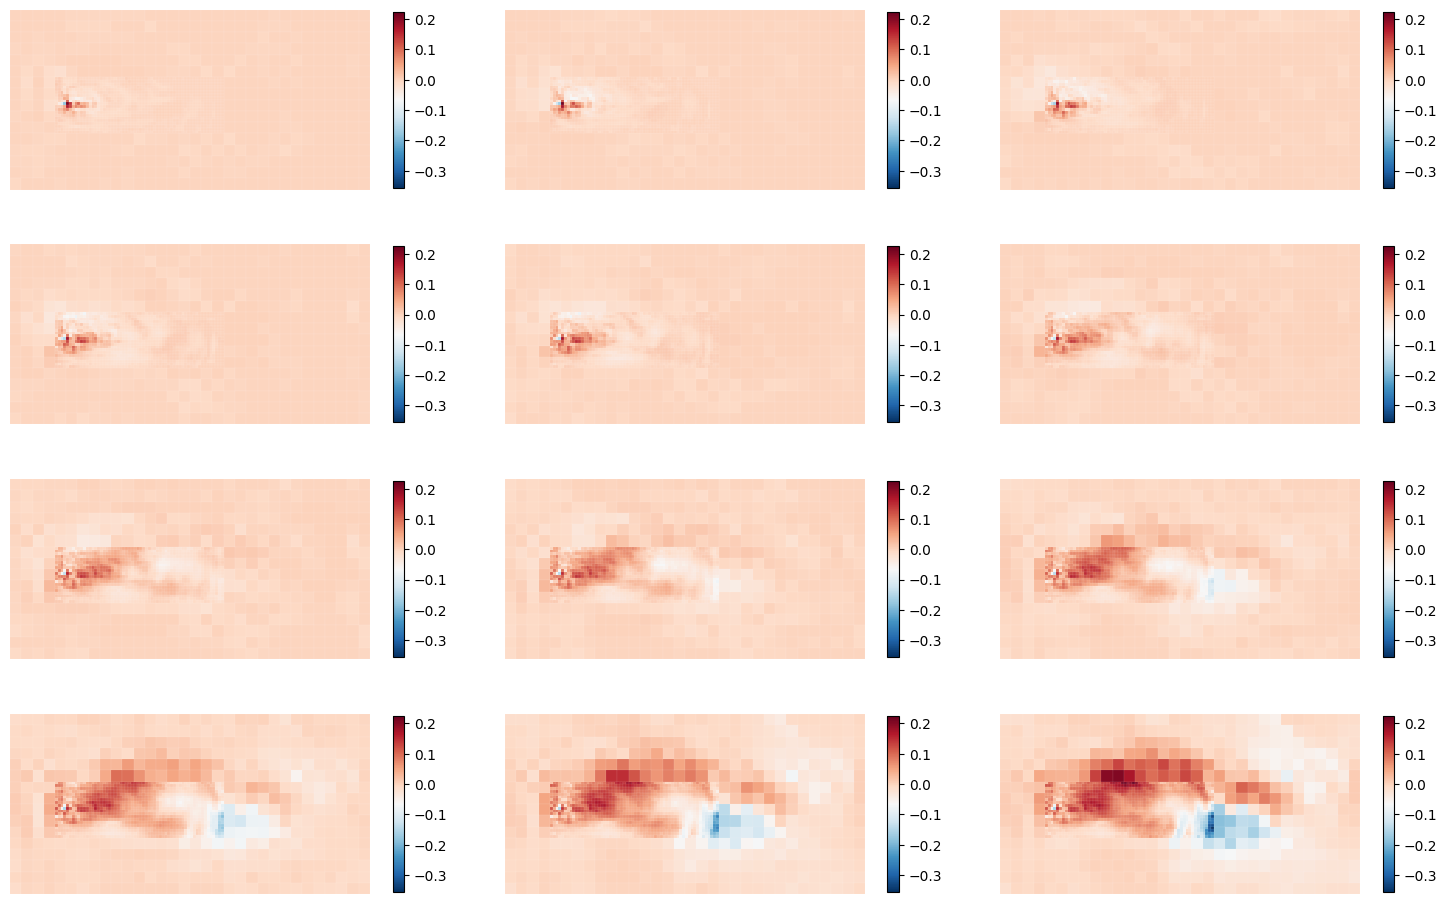

In [19]:
#LRGNN pred C error
plot_time_series(C_test[Num].transpose(1,0) - pred_c_last.transpose(1,0))